<a href="https://colab.research.google.com/github/HectorMaravillo/StreetNetworks/blob/main/PreliminaryProfile_StreetNetwork_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Perfil preliminar de las redes de calles en México**

Author: Héctor Maravillo

e-mail: hector.maravillo@im.unam.mx

Instituto de Matemáticas Unidad Cuernavaca, UNAM

Abril 2022

Código escrito en Python en la plataforma GoogleColaboratory

-------------------------------------------

-------------------------------------------

## **Contenido**: 

En este cuaderno virtual presentamos un código que permite extraer redes de calles de OpenStreetMap y realizar un perfil provisional de sus características a partir de la visualización de diferentes variables.

Los elementos mostrados para cada red son los siguientes:
1. Mapa de la red de calles.
2. Mapa de un $\beta$-esqueleto estimado por los vértices de la red, con $\beta = 1.4$.
3. Mapa de la centralidad de intermediación (betweenness centrality) de los 
vértices.
4. Histograma polar de la distribución de los ángulos de orientación de los segmentos de calle
5. Distribución del grado de los vértices 
4. Distribución de la longitud de los segmentos de calle
6. Distribución de la centralidad de intermediación de los vértices
7. Distribución del área de las caras definidas por la red de calles.
8. Distribución del factor de forma $\psi$ de las caras definidas por la red de calles.

#### **Notas:**

Debido al tiempo de computo, únicamente se pueden extraer pequeñas partes de la red de calles, a partir de una dirección y una distancia que define un cuadrado de extracción. Ver documentación de la libreria OSMnx.

Las definiciones pueden encontrarse en Barthelemy, 2018; Boeing, 2017; y Estrada, 2011.

Las documentación de las librerías de Python más importantes del código pueden encontrarse en:

> Geopandas (Datos geográfico): https://geopandas.org/en/stable/docs.html

> OSMnx (Extracción de redes de calles):  https://osmnx.readthedocs.io/en/stable/

> NetworkX (Analisis de gráficas y digráficas): https://networkx.org/

#### **Referencias**

> Barthelemy, M. (2018). Morphogenesis of Spatial Networks. Springer Nature.

> Boeing, G. (2017). Methods and measures for analyzing complex networks and urban form. Tesis doctoral. University of California, Berkeley.

> Estrada, E. (2011). The Structure of Complex Networks. Theory and Applications. Oxford University Press.

-------------------------------------------
-------------------------------------------

# Preliminares

In [ ]:
# Intalar las librerías. Despues reiniciar el entorno de ejecución y saltar esta celda.
!pip install --upgrade pyshp
!pip install --upgrade rtree
!pip install --upgrade pygeos
!pip install --upgrade shapely
!pip install --upgrade descartes
!pip install --upgrade geopandas
!pip install --upgrade osmnx
!pip install --upgrade matplotlib
!pip install ipython-autotime

In [ ]:
# Librerías
import numpy as np                        # Cálculo numérico y análisis de datos
import geopandas as gpd                   # Análisis de datos geográficos
import matplotlib.pyplot as plt           # Construcción de gráficas
import matplotlib.colors as colors        # Colores de Matplotlib
import matplotlib.cm as cm                # Colores de Matplotlib  
import seaborn as sb                      # Construcción de gráficas
import osmnx as ox                        # Extracción de redes de vialidades de OpenStreetMap
import networkx as nx                     # Construcción y análisis de gráficas y digráficas
import shapely                            # Manipulación de figuras geométricas en el plano (puntos, polilineas y polígonos)
import pandas as pd                       # Análisis y manipulación de datos

from itertools import combinations        # Combinaciones de un conjunto

%load_ext autotime
%matplotlib inline

## **Variables globlales**

In [ ]:
projection     = 6372
distance       = 1000
bins           = 30
buffer         = 2
fontsize_title = 14
fontsize_label = 10
node_size      = 30

## **Definición de funciones**

In [66]:
def Extract_StreetNetwork(city_name, distance):
  """ Extrae la red de calles dada una dirección y una distancia como una gráfica no dirigida de OpenStreetMap"""
  G = ox.graph_from_address(city_name, dist = distance, network_type = "drive")
  G = ox.add_edge_bearings(G)
  G = G.to_undirected()
  return G

def  Extract_Length(G):
  """ Extrae longitud de la gráfica de calles de OpenStreetMap"""
  l      = []
  for e in G.edges(data=True):
    l.append(e[2]["length"])
  length = np.array(l)
  length = np.sort(length)
  return length

def Extract_Degree(G):
  """ Extrae la secuencia de grado de una gráfica"""
  degree_sequence = np.array([d for n, d in G.degree()])
  degree_sequence = np.sort(degree_sequence)
  return degree_sequence

def Calculate_ShapeFactor(polygon):
  exterior_points =  np.array(polygon.exterior.coords) 
  radius          = 0
  for pair in combinations(exterior_points,2):
    d  = np.linalg.norm(pair[0]-pair[1])
    if d > radius:
      radius = d
  shape_factor = (4*polygon.area)/(np.pi*np.power(radius,2))
  return shape_factor

def Extract_Blocks(G, buffer):
  """ Estima la geometría de las manzanas a partir de una red de calles de OSM """
  intersection, streets = ox.graph_to_gdfs(G)
  intersection.to_crs(projection, inplace = True)
  streets.to_crs(projection, inplace = True)
  convexhull            = intersection.geometry.unary_union.convex_hull
  streets_buffer        = streets.geometry.buffer(buffer)
  del intersection, streets
  streets_buffer        = streets_buffer.geometry.unary_union
  blocks_geometry       = convexhull.difference(streets_buffer)
  blocks                = gpd.GeoDataFrame()
  if blocks_geometry.type   == "MultiPolygon":
    blocks["geometry"]      = blocks_geometry.geoms
  elif blocks_geometry.type == "Polygon":
    blocks["geometry"]      = blocks_geometry
  blocks.set_crs(projection)
  blocks["Area"]        = blocks.geometry.area
  blocks["ShapeFactor"] = blocks.geometry.apply(Calculate_ShapeFactor)
  return blocks

def Extract_BetweennessCentrality(G, type_BC = "nodes"):
  if type_BC == "nodes":
    node_centrality = nx.betweenness_centrality(G = G, normalized=True, weight  = "length")
    return node_centrality
  elif type_BC == "edges":
    edge_centrality = nx.edge_betweenness(G=G, normalized=True, weight  = "length")
    return edge_centrality

def Draw_Node_BetweennessCentrality(G, betweenness, ax):
  df = pd.DataFrame(data=pd.Series(betweenness).sort_values(), columns=['cc'])
  df['colors'] = ox.plot.get_colors(n=len(df), cmap='plasma')
  df = df.reindex(G.nodes())
  nc = df['colors'].tolist()
  fig, ax = ox.plot_graph(G, bgcolor='k',  ax = ax, node_size=node_size, node_color=nc, node_edgecolor='none', node_zorder=2,
                        edge_color='#555555', edge_linewidth=1.5, edge_alpha=1, show = False)

def Intersection_Region(u,v,beta):
  """ Función para construir la región de intersección de los beta-esqueletos para beta=<1 (basado en lunas y circulos)
  Devuelve el centro de cada circulo y su radio.
  Véase Alonso, L., Méndez-Bermúdez, J.A., Estrada, E., (2021) para la definción de la región"""
  d  = np.linalg.norm(u-v)
  r  = d/(2*beta)
  R  = np.array([[0,-1],[1,0]] )
  c1 = (u+v)/2 + np.dot(R,v-u)*np.power(1-np.power(beta,2), 0.5)/(2*beta)
  c2 = (u+v)/2 - np.dot(R,v-u)*np.power(1-np.power(beta,2), 0.5)/(2*beta)
  return {"c1": c1, "c2": c2, "r": r}

def Lune_Region(u,v,beta):
  """ Función para construir la región de intersección de los beta-esqueletos basados en lunas para beta>1
  Devuelve el centro de cada circulo y su radio.
  Véase Alonso, L., Méndez-Bermúdez, J.A., Estrada, E., (2021) para la definción de la región"""
  d = np.linalg.norm(u-v)                                                      
  beta_aux = beta/2
  r = beta_aux*d
  c1 = u*beta_aux + (1-beta_aux)*v
  c2 = v*beta_aux + (1-beta_aux)*u
  return {"c1": c1, "c2": c2, "r": r}

def Circle_Region(u,v,beta):
  """ Función para construir la región de intersección de los beta-esqueletos basados en circulos
  Devuelve el centro de cada circulo y su radio.
  Véase Alonso, L., Méndez-Bermúdez, J.A., Estrada, E., (2021) para la definción de la región"""
  d  = np.linalg.norm(u-v)                                                     
  r  = (beta*d)/2
  R  = np.array([[0,-1],[1,0]] )
  c1 = (u+v)/2 + np.dot(R,v-u)*np.power(np.power(beta,2)-1, 0.5)/2
  c2 = (u+v)/2 - np.dot(R,v-u)*np.power(np.power(beta,2)-1, 0.5)/2
  return {"c1": c1, "c2": c2, "r": r}

def Beta_Skeleton(G, beta, method="lune-based"):
  """ Función para construir el beta-esqueleto de una red"""
  H      = nx.create_empty_copy(G, with_data=True)                            # Crea una copia de la red sin aristas
  for pair in combinations(G.nodes(),2):                                      # Itera sobre todos los pares de vértices u,v
    u            = np.array([G.nodes[pair[0]]["x"], G.nodes[pair[0]]["y"]])
    v            = np.array([G.nodes[pair[1]]["x"], G.nodes[pair[1]]["y"]])
    if beta <= 1:
      search_region = Intersection_Region(u,v, beta) 
    elif method == "lune-based":                                              # Beta-esqueletos basados en lunas
      search_region = Lune_Region(u,v, beta)                                  
    elif method == "circle-based":                                            # Beta-esqueletos basados en circulos
      search_region = Circle_Region(u,v, beta)
    empty_test   = True                                                      
    for z in G.nodes():            
      if z not in set(pair):                                                  # Itera sobre todos los vértices z diferentes al par u,v
        z_coord    = np.array([G.nodes[z]["x"], G.nodes[z]["y"]])             # Extrae coordenadas del vértice z
        dist_1     = np.linalg.norm(z_coord-search_region["c1"])              # Distancia en el plano entre z y el centro 1
        dist_2     = np.linalg.norm(z_coord-search_region["c2"])              # Distancia en el plano entre z y el centro 2
        if method  == "lune-based": 
          if dist_1 <= search_region["r"]:
            if dist_2 <= search_region["r"]:                                  # Comprueba que z se encuentre en la región de intersección 
              empty_test = False
              break
        elif method == "circle-based": 
          if beta <= 1:
            if dist_1 <= search_region["r"]: 
              if dist_2 <= search_region["r"]:                                # Comprueba que z se encuentre en la región de intersección 
                empty_test = False
                break
          else:
            if dist_1 <= search_region["r"]:                                  # Comrpueba que z se encuentra en la región de union
              empty_test = False
              break
            elif dist_2 <= search_region["r"]:
              empty_test = False
              break
    if empty_test  == True:                                                   
      H.add_edge(pair[0], pair[1])                                            # Si la región de intersección está vacia agrega una arista entre u,v
  ox.distance.add_edge_lengths(H)
  return H

time: 433 ms (started: 2022-04-26 16:39:51 +00:00)


In [62]:
def StreetNetworks_Analysis(G, city_name):
  G2 = nx.Graph(G)
  G3 = nx.MultiGraph(G2)
  node_centrality = Extract_BetweennessCentrality(G2, "nodes")
  degree = Extract_Degree(G2)
  length = Extract_Length(G2)
  blocks = Extract_Blocks(G3, buffer)

  fig = plt.figure(figsize = (25, 10))

  # Show map of network street
  ax1 = fig.add_subplot(2,4,1)
  G_stats = "n: " + str(G.order()) + "  m: " + str(G.size())
  ax1.title.set_text('Red de calles (' + city_name + ")\n" + G_stats)
  ox.plot_graph(G, show = False, close = False, node_color = "black", edge_color = "black", ax = ax1, node_size  = node_size)

  ax2 = fig.add_subplot(2,4,2)
  H = Beta_Skeleton(G, 1.4)
  H_stats = "n: " + str(H.order()) + "  m: " + str(H.size())
  ox.plot_graph(H,  node_color = "black", ax =ax2, edge_color = "red", show=False)   
  ax2.title.set_text('$B$-Esqueleto ($B$='+str(1.4)+')\n' + H_stats)    

  # Show map of betweenness centrality by nodes
  ax3 = fig.add_subplot(2,4,3)
  ax3.title.set_text('Centralidad de intermediación por nodo')  
  Draw_Node_BetweennessCentrality(G3, node_centrality, ax3)

  # Show histogram of street angle orientation
  ax4 = fig.add_subplot(2,4,4, projection='polar')
  ax4.title.set_text('Histograma polar de la orientación de segmentos de calle') 
  ox.plot_orientation(G, num_bins  = 36, ax = ax4, weight = "length")

  # Show degree distribution
  ax5 = fig.add_subplot(2,4,5)
  sb.histplot(degree, discrete = True, ax = ax5, stat = "probability")
  ax5.title.set_text('Distribución del grado')  
  ax5.set_ylabel("Probabilidad", {'fontsize': fontsize_label})
  ax5.set_xlabel("Grados", {'fontsize': fontsize_label})
  ax5.set_xticks(list(set(degree)))

  # Show length distribution
  ax6 = fig.add_subplot(2,4,6)
  sb.histplot(length, ax = ax6, bins = bins, stat = "probability", kde = True)
  ax6.title.set_text('Distribución de la longitud de segmentos de calles')  
  ax6.set_xlabel("Longitud ($m$)", {'fontsize': fontsize_label})
  ax6.set_ylabel("Probabilidad", {'fontsize': fontsize_label})

  # Show face area distribution
  ax7 = fig.add_subplot(2,4,7)
  sb.histplot(blocks["Area"], ax = ax7, bins = bins, stat = "probability", kde = True)
  ax7.set_title("Distribución del área de las caras", {'fontsize': fontsize_title})
  ax7.set_xlabel("Área ($m^2$)", {'fontsize': fontsize_label})

  # Show face shape factor distribution
  ax8 = fig.add_subplot(2,4,8)
  sb.histplot(blocks["ShapeFactor"], ax = ax8, bins = bins, stat = "probability", kde = True)
  ax8.set_title("Distribución del factor de forma de las caras", {'fontsize': fontsize_title})
  ax8.set_xlabel("Factor de forma $\phi$", {'fontsize': fontsize_label})


time: 110 ms (started: 2022-04-26 16:37:51 +00:00)


# **Ejemplos de perfiles de redes de calles del centro de las ciudades (1km)**


## **Mérida, Yucatán**


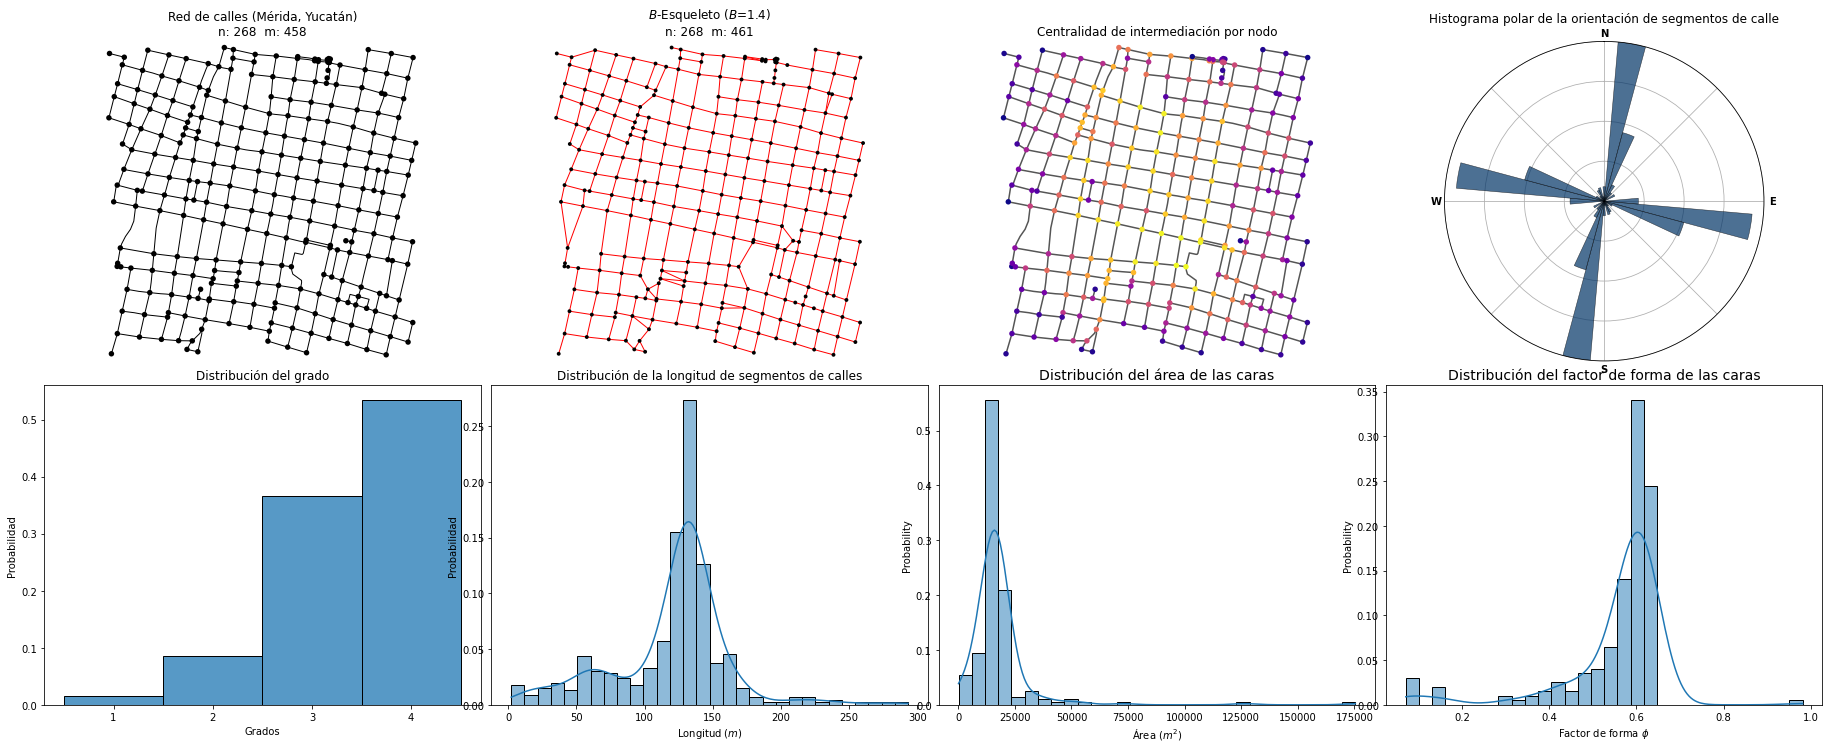

time: 16.4 s (started: 2022-04-26 16:39:55 +00:00)


In [67]:
city_name = "Mérida, Yucatán"
Mérida    = Extract_StreetNetwork(city_name, distance)
StreetNetworks_Analysis(Mérida, city_name)

## **Ciudad de México**

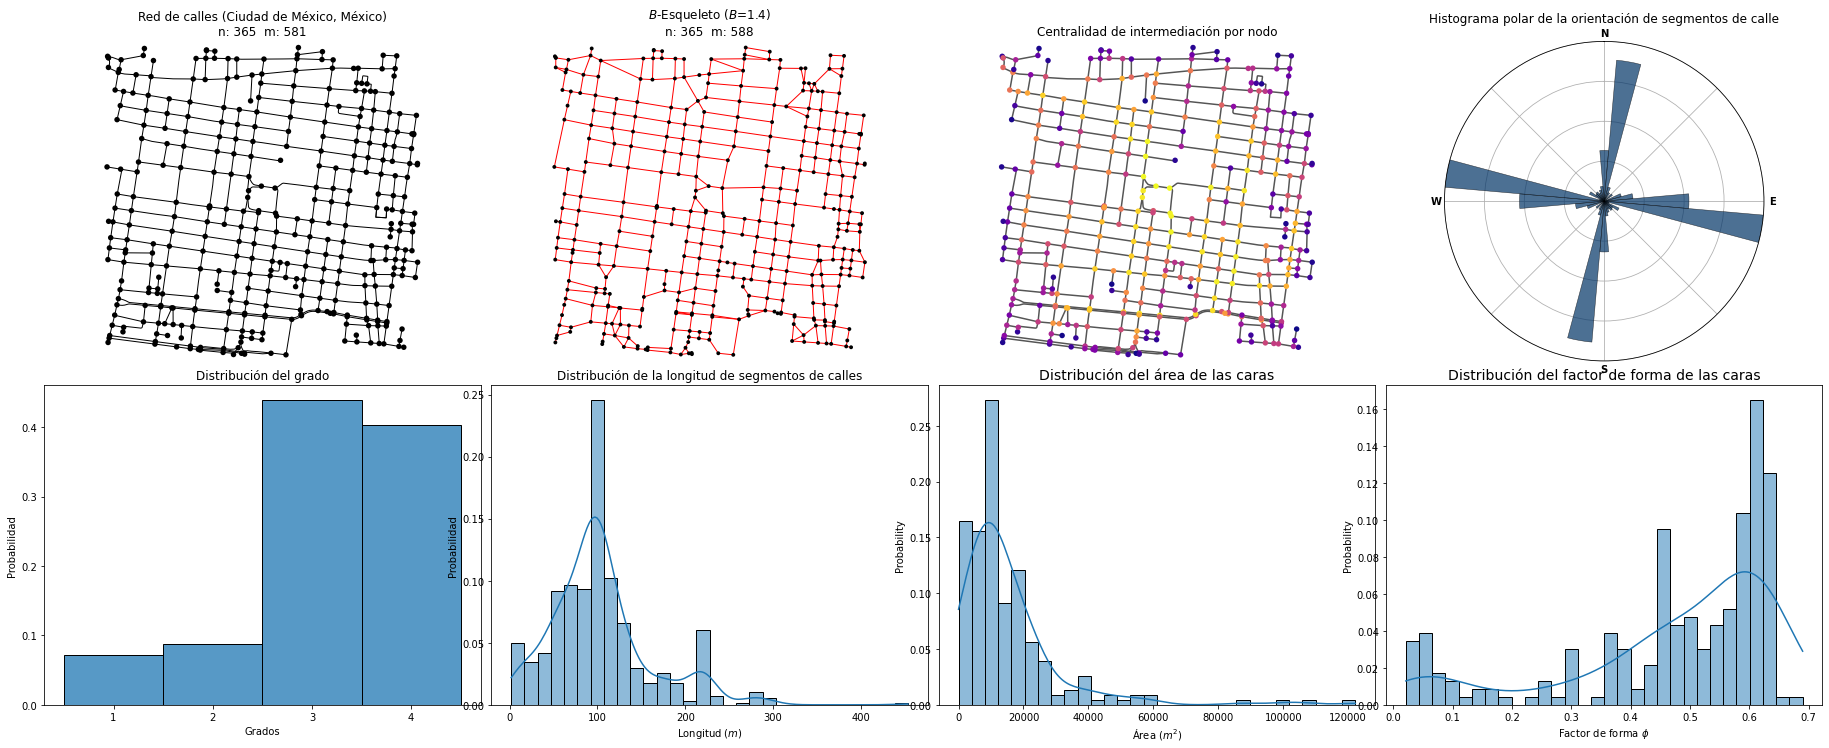

time: 56.8 s (started: 2022-04-26 16:40:41 +00:00)


In [68]:
city_name = "Ciudad de México, México"
Cdmx      = Extract_StreetNetwork(city_name, distance)
StreetNetworks_Analysis(Cdmx, city_name)

## **Cuernavaca, Morelos**

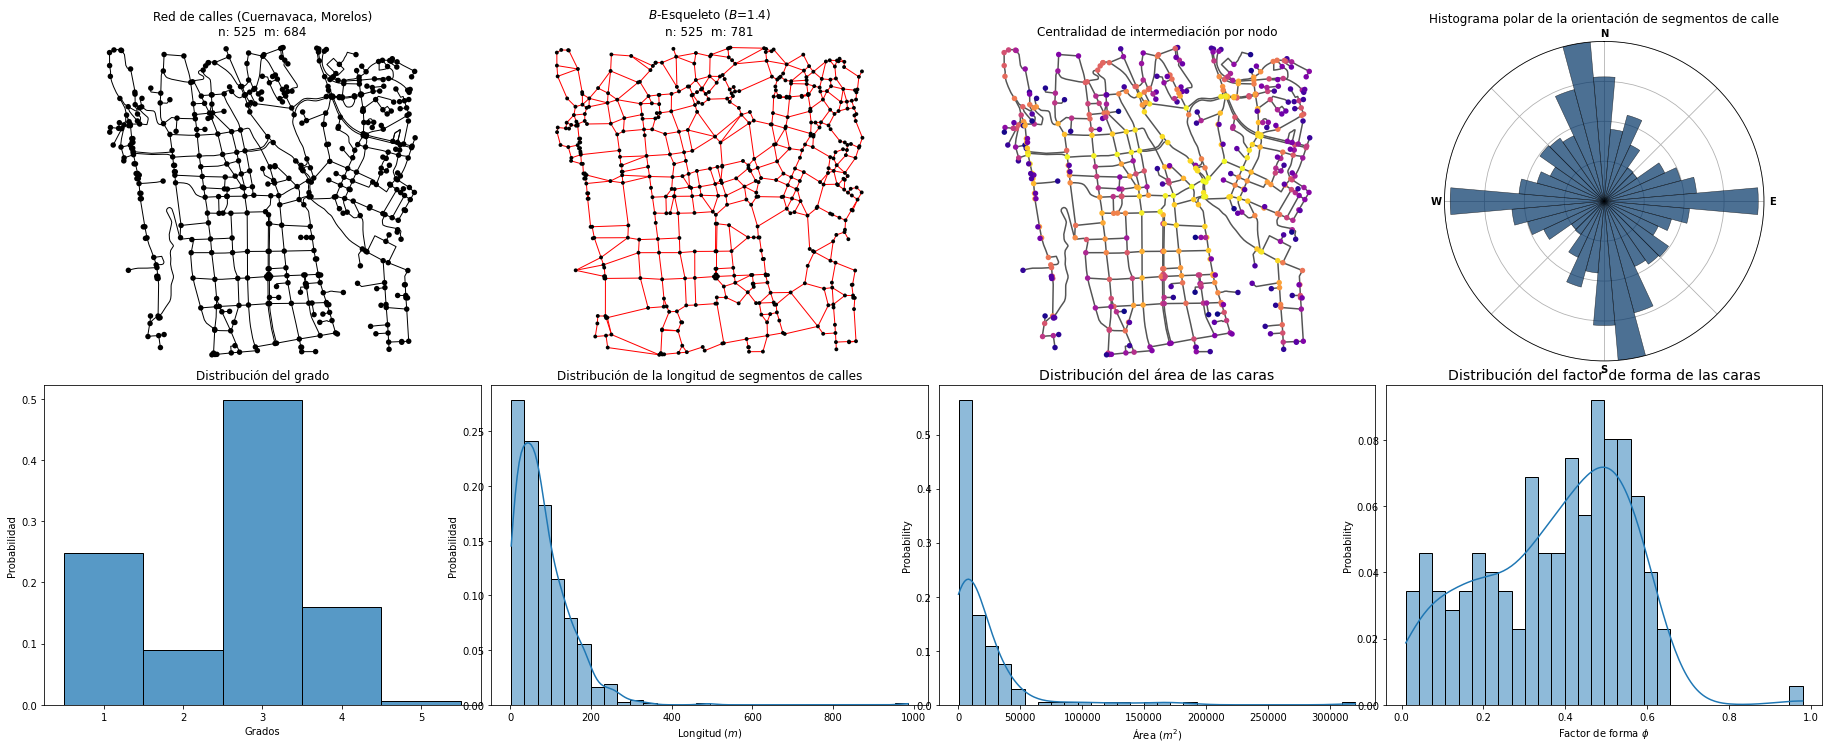

time: 1min 34s (started: 2022-04-26 16:42:19 +00:00)


In [71]:
city_name  = "Cuernavaca, Morelos"
Cuernavaca = Extract_StreetNetwork(city_name, distance)
StreetNetworks_Analysis(Cuernavaca, city_name)

## **Ciudad de Oaxaca**

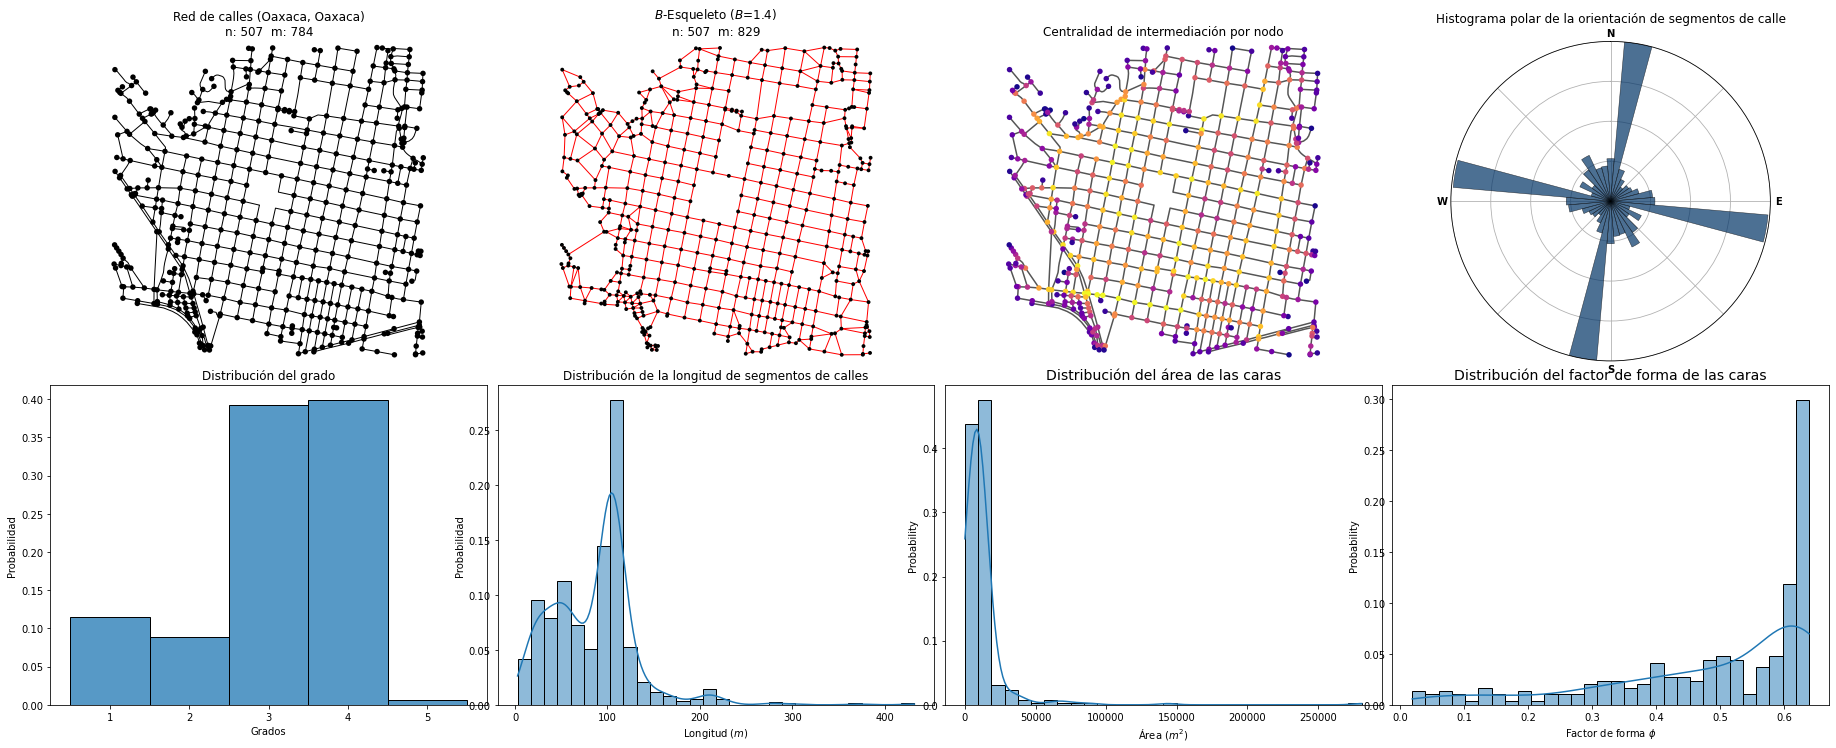

time: 1min 13s (started: 2022-04-26 16:43:54 +00:00)


In [72]:
city_name = "Oaxaca, Oaxaca"
Oaxaca    = Extract_StreetNetwork(city_name, distance)
StreetNetworks_Analysis(Oaxaca, city_name)

## **Ciudad de Guanajuato**

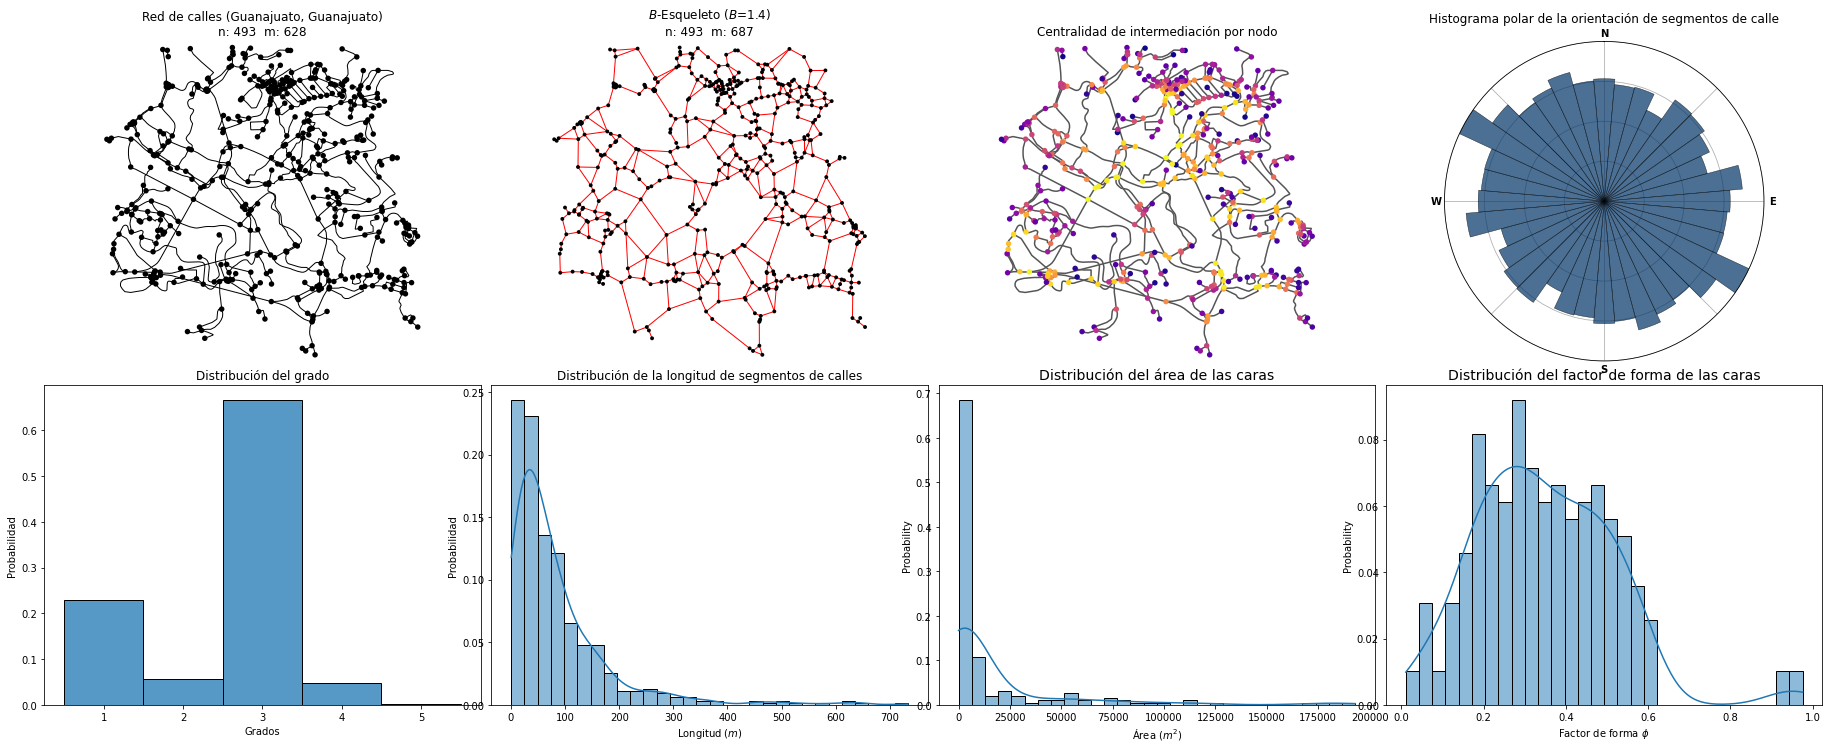

time: 1min 32s (started: 2022-04-26 16:45:07 +00:00)


In [73]:
city_name  = "Guanajuato, Guanajuato"
Guanajuato = Extract_StreetNetwork(city_name, distance)
StreetNetworks_Analysis(Guanajuato, city_name)

## **Ciudad de Acapulco**

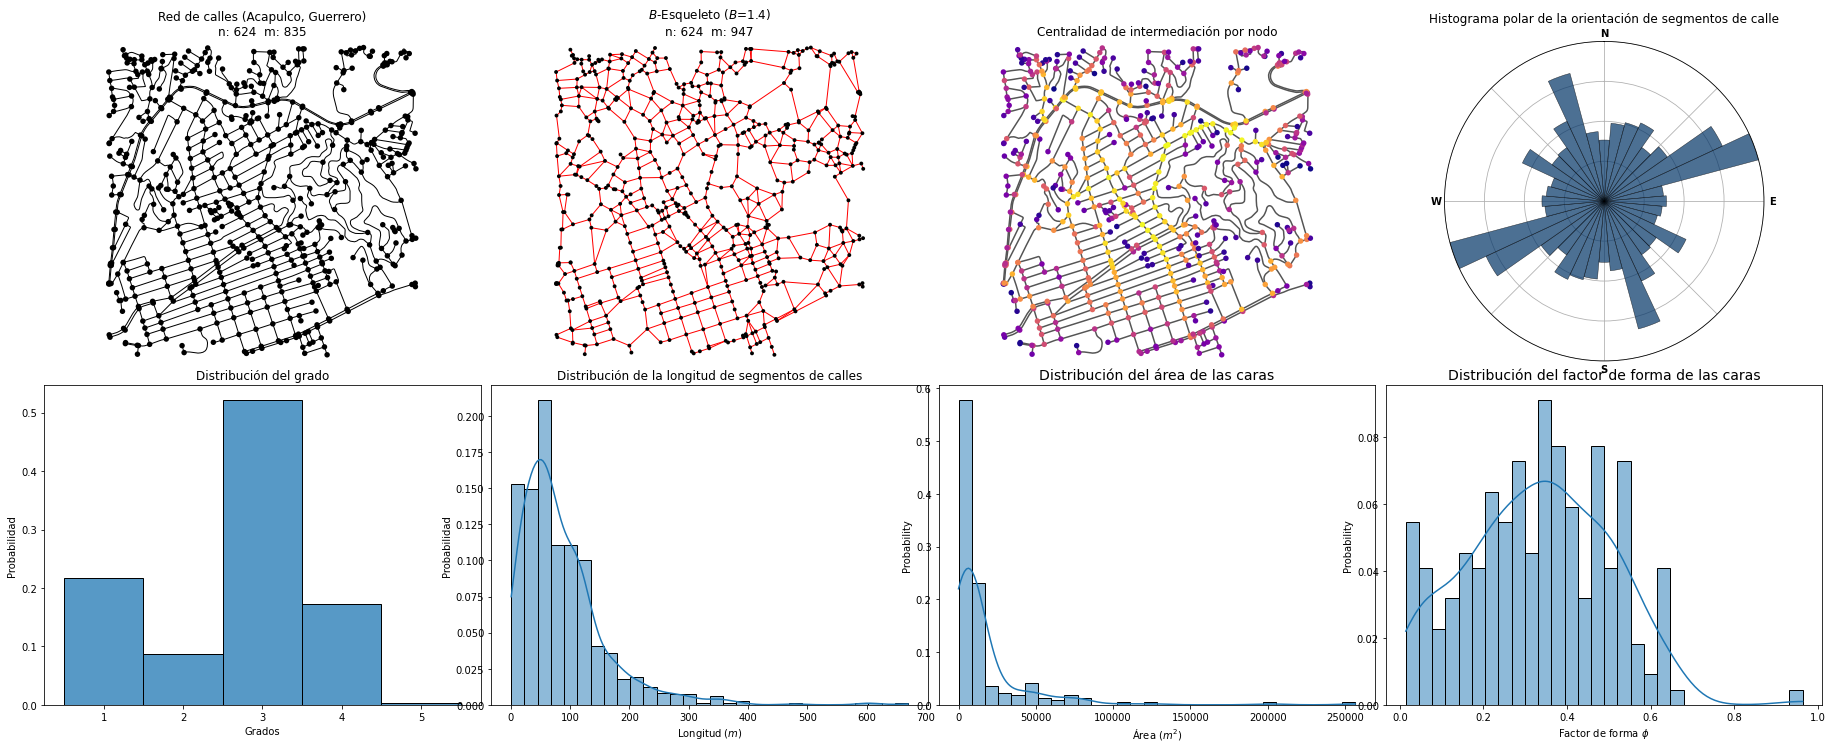

time: 4min 27s (started: 2022-04-26 16:46:40 +00:00)


In [74]:
city_name  = "Acapulco, Guerrero"
Acapulco = Extract_StreetNetwork(city_name, distance)
StreetNetworks_Analysis(Acapulco, city_name)

## **Cárdenas, Tabasco (10km)**

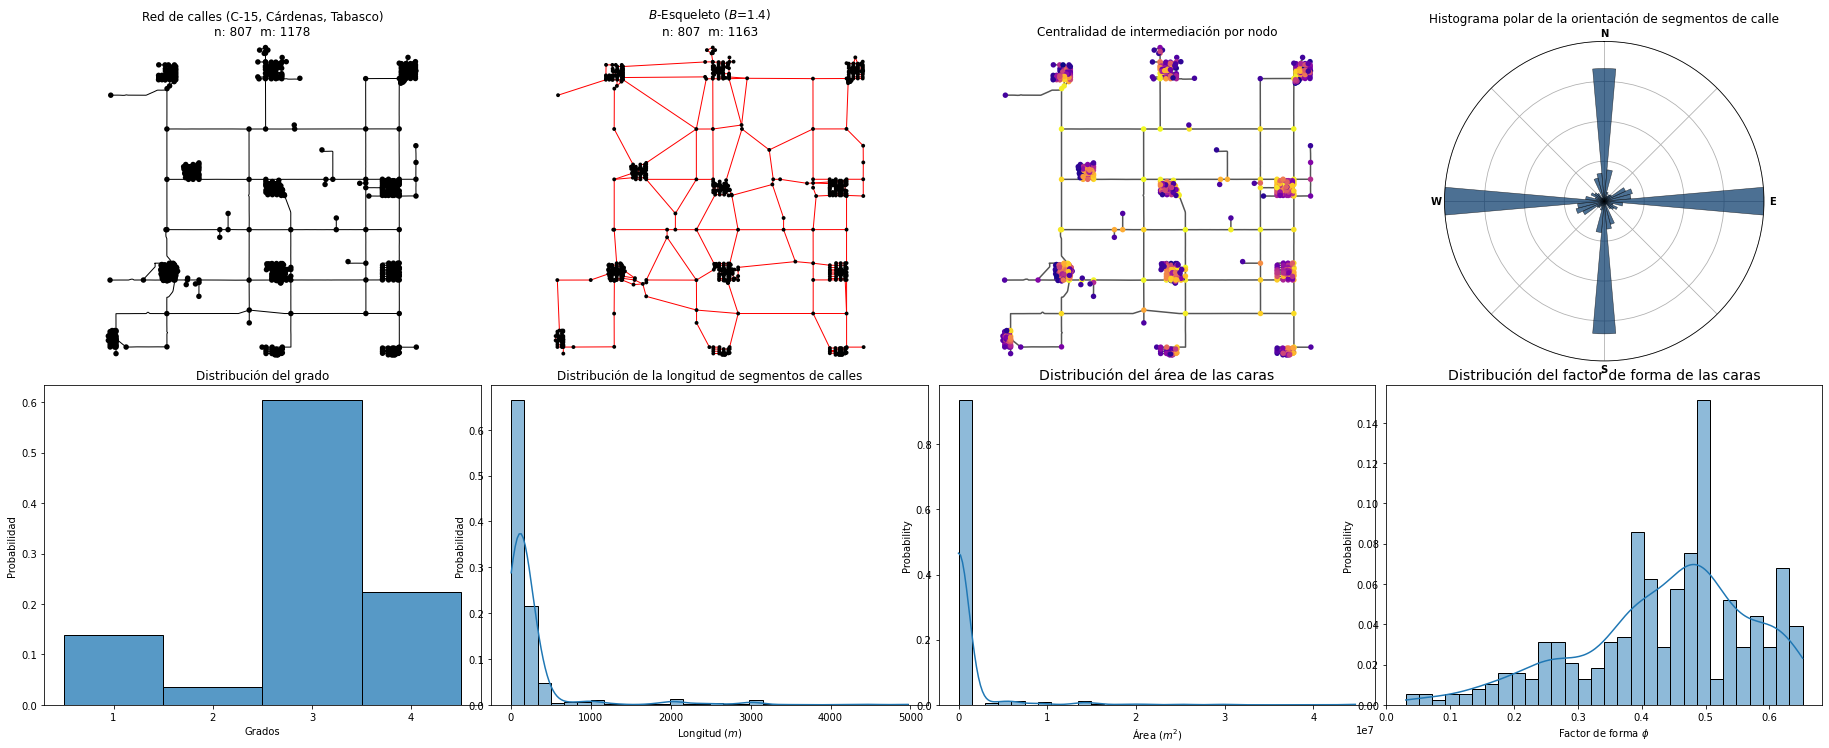

time: 5min 7s (started: 2022-04-26 16:51:08 +00:00)


In [75]:
city_name = "C-15, Cárdenas, Tabasco"
Cárdenas    = Extract_StreetNetwork(city_name, 10000)
StreetNetworks_Analysis(Cárdenas, city_name)

## **Tres Marías, Morelos (5km)**

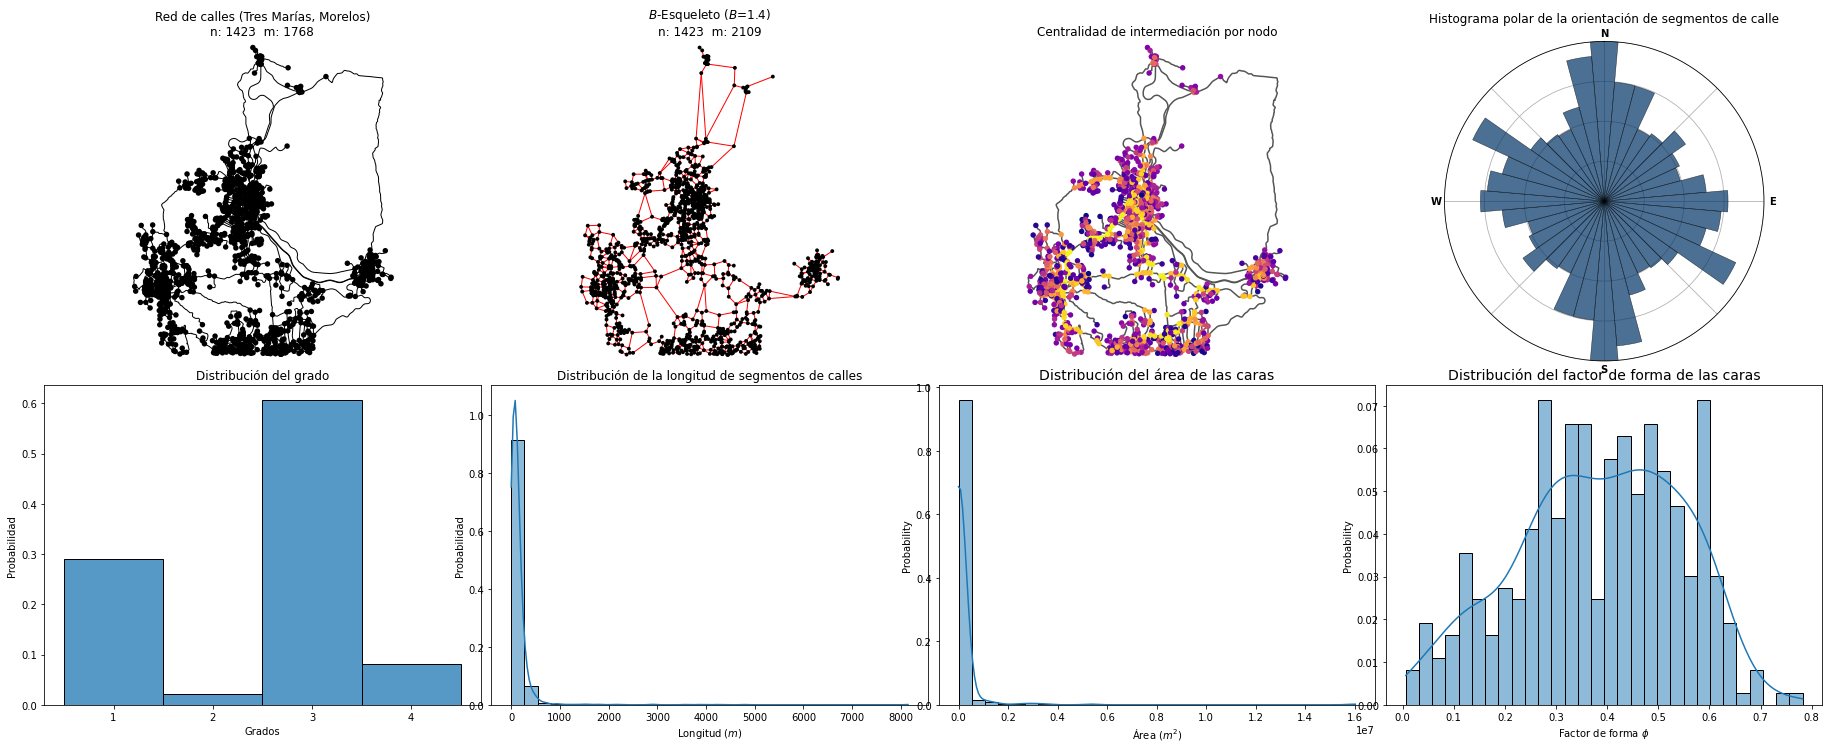

time: 13min 10s (started: 2022-04-26 16:56:15 +00:00)


In [76]:
city_name = "Tres Marías, Morelos"
Cárdenas    = Extract_StreetNetwork(city_name, 5000)
StreetNetworks_Analysis(Cárdenas, city_name)